Vid2Act mean grad_cos_sim: 0.302489
COMET   mean grad_cos_sim: 0.029436


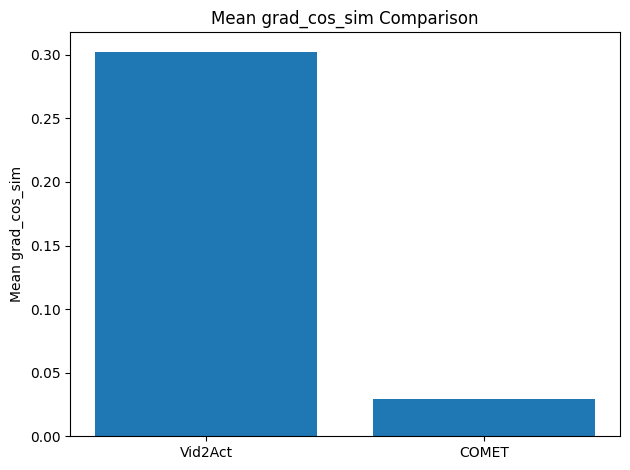

In [1]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

def extract_grad_cos_sim_mean(jsonl_path):
    """
    Extract all grad_cos_sim values from a jsonl file and return their mean.
    """
    grad_values = []

    with open(jsonl_path, "r") as f:
        for line in f:
            data = json.loads(line)
            for key, value in data.items():
                if "grad_cos_sim" in key and isinstance(value, (int, float)):
                    grad_values.append(value)

    if not grad_values:
        raise ValueError(f"No grad_cos_sim values found in {jsonl_path}")

    return sum(grad_values) / len(grad_values)


# -------- paths to your files --------
vid2act_path = "/storage/ssd1/richtsai1103/vid2act/models/mt6_10_top50/original/metrics.jsonl"
comet_path = "/storage/ssd1/richtsai1103/vid2act/models/moe_new/metrics.jsonl"

# -------- compute means --------
vid2act_mean = extract_grad_cos_sim_mean(vid2act_path)
comet_mean = extract_grad_cos_sim_mean(comet_path)

print(f"Vid2Act mean grad_cos_sim: {vid2act_mean:.6f}")
print(f"COMET   mean grad_cos_sim: {comet_mean:.6f}")

# -------- plot comparison --------
labels = ["Vid2Act", "COMET"]
means = [vid2act_mean, comet_mean]

plt.figure()
plt.bar(labels, means)
plt.ylabel("Mean grad_cos_sim")
plt.title("Mean grad_cos_sim Comparison")

plt.tight_layout()
plt.show()


Vid2Act 6x6 mean grad_cos_sim (raw):
 [[       nan 0.34119514 0.3700093  0.35999221 0.1896131  0.1689209 ]
 [       nan        nan 0.42072305 0.39546643 0.2226276  0.2059556 ]
 [       nan        nan        nan 0.4111358  0.28170092 0.26126275]
 [       nan        nan        nan        nan 0.30115646 0.23699818]
 [       nan        nan        nan        nan        nan 0.37057164]
 [       nan        nan        nan        nan        nan        nan]]
Vid2Act 6x6 mean grad_cos_sim (symmetrized):
 [[       nan 0.34119514 0.3700093  0.35999221 0.1896131  0.1689209 ]
 [0.34119514        nan 0.42072305 0.39546643 0.2226276  0.2059556 ]
 [0.3700093  0.42072305        nan 0.4111358  0.28170092 0.26126275]
 [0.35999221 0.39546643 0.4111358         nan 0.30115646 0.23699818]
 [0.1896131  0.2226276  0.28170092 0.30115646        nan 0.37057164]
 [0.1689209  0.2059556  0.26126275 0.23699818 0.37057164        nan]]
COMET 6x6 mean grad_cos_sim (raw):
 [[        nan  0.04608576  0.05737343  0.02465245 

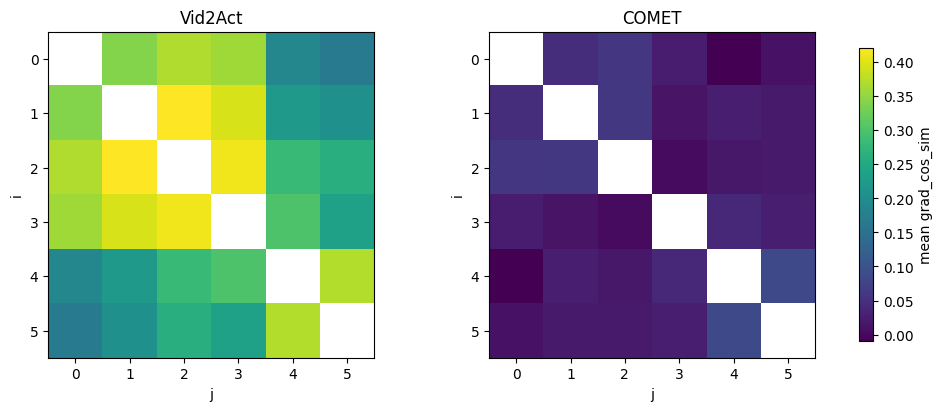

In [5]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Extract / aggregate grad_cos_sim into a 6x6 mean matrix
# ----------------------------

IDX_PATTERNS = [
    re.compile(r"grad_cos_sim\[(\d+)\]\[(\d+)\]"),  # grad_cos_sim[0][5]
    re.compile(r"grad_cos_sim\[(\d+),\s*(\d+)\]"),  # grad_cos_sim[0,5]
    re.compile(r"grad_cos_sim_(\d+)_(\d+)"),        # grad_cos_sim_0_5
    re.compile(r"grad_cos_sim\.(\d+)\.(\d+)"),      # grad_cos_sim.0.5
    re.compile(r"grad_cos_sim/(\d+)/(\d+)"),        # grad_cos_sim/0/5
]

def _accumulate_cell_sums_counts(sums, counts, i, j, v, n=6):
    if 0 <= i < n and 0 <= j < n and isinstance(v, (int, float)) and np.isfinite(v):
        sums[i, j] += float(v)
        counts[i, j] += 1

def _ingest_nested_matrix(sums, counts, mat, n=6):
    try:
        arr = np.array(mat, dtype=float)
    except Exception:
        return
    if arr.ndim != 2:
        return
    if arr.shape[0] < n or arr.shape[1] < n:
        return
    for i in range(n):
        for j in range(n):
            v = arr[i, j]
            if np.isfinite(v):
                sums[i, j] += float(v)
                counts[i, j] += 1

def extract_grad_cos_sim_heatmap_mean(jsonl_path, n=6):
    """
    Reads a JSONL metrics file and returns an (n x n) matrix where each cell is the mean
    of all observed grad_cos_sim[i,j] values across the file (NaN if never observed).
    """
    sums = np.zeros((n, n), dtype=float)
    counts = np.zeros((n, n), dtype=int)

    with open(jsonl_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)

            # Case A: direct nested matrix under "grad_cos_sim"
            if "grad_cos_sim" in obj:
                _ingest_nested_matrix(sums, counts, obj["grad_cos_sim"], n=n)

            # Case B: scan obj and obj["metrics"] for key-encoded indices and/or nested matrices
            for container in (obj, obj.get("metrics", {})):
                if not isinstance(container, dict):
                    continue
                for k, v in container.items():
                    if not isinstance(k, str) or "grad_cos_sim" not in k:
                        continue

                    # nested matrix as value
                    if isinstance(v, (list, tuple, np.ndarray)):
                        _ingest_nested_matrix(sums, counts, v, n=n)
                        continue

                    # scalar keyed by indices in key name
                    if isinstance(v, (int, float)):
                        for pat in IDX_PATTERNS:
                            m = pat.search(k)
                            if m:
                                i, j = int(m.group(1)), int(m.group(2))
                                _accumulate_cell_sums_counts(sums, counts, i, j, v, n=n)
                                break

            # Case C: one-level nested dicts in obj
            for _, maybe_dict in obj.items():
                if not isinstance(maybe_dict, dict):
                    continue
                for k, v in maybe_dict.items():
                    if isinstance(k, str) and "grad_cos_sim" in k and isinstance(v, (int, float)):
                        for pat in IDX_PATTERNS:
                            m = pat.search(k)
                            if m:
                                i, j = int(m.group(1)), int(m.group(2))
                                _accumulate_cell_sums_counts(sums, counts, i, j, v, n=n)
                                break

    mean = np.full((n, n), np.nan, dtype=float)
    mask = counts > 0
    mean[mask] = sums[mask] / counts[mask]

    if not np.any(mask):
        raise ValueError(f"No grad_cos_sim values found in {jsonl_path}")

    return mean

# ----------------------------
# Symmetry fill (robust)
# ----------------------------

def symmetrize_fill(mat, diagonal="keep", conflict="mean", fill_missing="nan"):
    """
    Make a matrix symmetric by filling NaNs using the transpose.

    diagonal:
      - "keep" (default): do nothing
      - "zero": set diag to 0
      - "nan": set diag to NaN

    conflict (when both mat[i,j] and mat[j,i] are finite but differ):
      - "keep": keep mat[i,j] and force mat[j,i]=mat[i,j]
      - "mean": set both to their average (recommended)

    fill_missing (if both sides are NaN):
      - "nan": keep as NaN
      - "zero": set to 0
      - "mean": set to global mean of finite cells
    """
    m = mat.copy()
    n = m.shape[0]
    assert m.shape[1] == n, "matrix must be square"

    for i in range(n):
        for j in range(i + 1, n):
            a = m[i, j]
            b = m[j, i]
            a_f = np.isfinite(a)
            b_f = np.isfinite(b)

            if a_f and not b_f:
                m[j, i] = a
            elif b_f and not a_f:
                m[i, j] = b
            elif a_f and b_f:
                if conflict == "mean":
                    v = 0.5 * (a + b)
                    m[i, j] = v
                    m[j, i] = v
                elif conflict == "keep":
                    m[j, i] = m[i, j]
            # else both NaN -> leave as missing

    if diagonal == "zero":
        np.fill_diagonal(m, 0.0)
    elif diagonal == "nan":
        np.fill_diagonal(m, np.nan)

    missing = ~np.isfinite(m)
    if np.any(missing):
        if fill_missing == "zero":
            m[missing] = 0.0
        elif fill_missing == "mean":
            finite = m[np.isfinite(m)]
            m[missing] = float(np.mean(finite)) if finite.size else 0.0

    return m

# ----------------------------
# Plot: two heatmaps side-by-side with shared color scale
# ----------------------------

def plot_two_heatmaps(mat_a, mat_b, name_a="Vid2Act", name_b="COMET"):
    finite_a = mat_a[np.isfinite(mat_a)]
    finite_b = mat_b[np.isfinite(mat_b)]
    if finite_a.size + finite_b.size:
        combined = np.concatenate([finite_a, finite_b])
        vmin, vmax = float(np.min(combined)), float(np.max(combined))
    else:
        vmin, vmax = 0.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    im0 = axes[0].imshow(mat_a, vmin=vmin, vmax=vmax, aspect="equal")
    axes[0].set_title(name_a)
    axes[0].set_xlabel("j")
    axes[0].set_ylabel("i")
    axes[0].set_xticks(range(mat_a.shape[1]))
    axes[0].set_yticks(range(mat_a.shape[0]))

    im1 = axes[1].imshow(mat_b, vmin=vmin, vmax=vmax, aspect="equal")
    axes[1].set_title(name_b)
    axes[1].set_xlabel("j")
    axes[1].set_ylabel("i")
    axes[1].set_xticks(range(mat_b.shape[1]))
    axes[1].set_yticks(range(mat_b.shape[0]))

    cbar = fig.colorbar(im1, ax=axes, shrink=0.9)
    cbar.set_label("mean grad_cos_sim")

    plt.show()

# ----------------------------
# MAIN
# ----------------------------

vid2act_path = "/storage/ssd1/richtsai1103/vid2act/models/mt6_10_top50/original/metrics.jsonl"
comet_path   = "/storage/ssd1/richtsai1103/vid2act/models/moe_new/metrics.jsonl"

vid2act_hm = extract_grad_cos_sim_heatmap_mean(vid2act_path, n=6)
comet_hm   = extract_grad_cos_sim_heatmap_mean(comet_path,   n=6)

# Apply symmetry fix:
# - conflict="mean" averages if both sides exist but differ
# - fill_missing="nan" keeps truly-missing pairs as NaN
#   (use "zero" or "mean" if you want a fully-filled 6x6 no matter what)
vid2act_full = symmetrize_fill(vid2act_hm, diagonal="keep", conflict="mean", fill_missing="nan")
comet_full   = symmetrize_fill(comet_hm,   diagonal="keep", conflict="mean", fill_missing="nan")

print("Vid2Act 6x6 mean grad_cos_sim (raw):\n", vid2act_hm)
print("Vid2Act 6x6 mean grad_cos_sim (symmetrized):\n", vid2act_full)
print("COMET 6x6 mean grad_cos_sim (raw):\n", comet_hm)
print("COMET 6x6 mean grad_cos_sim (symmetrized):\n", comet_full)

plot_two_heatmaps(vid2act_full, comet_full, name_a="Vid2Act", name_b="COMET")


Vid2Act steps: [1999 3999 5999 7999 9999] ... [189999 191999 193999 195999 197999]
COMET   steps: [1999 3999 5999 7999 9999] ... [189999 191999 193999 195999 197999] (shifted by +13)


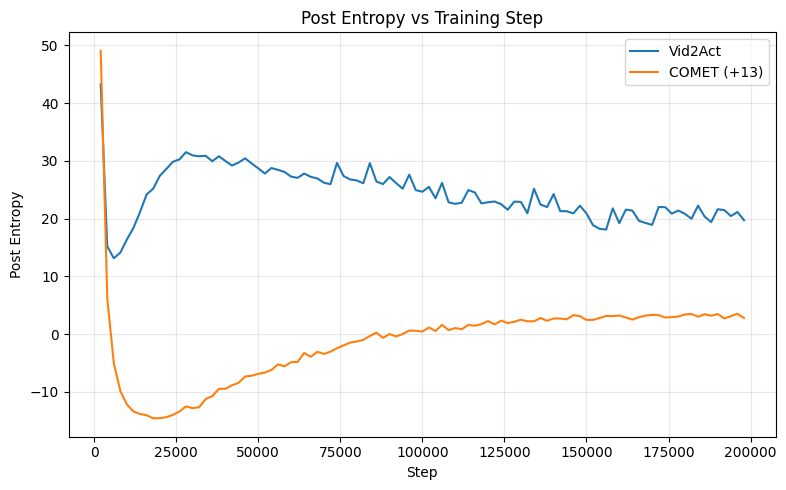

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------
# Extract post-entropy vs step
# ----------------------------

POST_ENTROPY_KEYS = [
    "post_ent",
    "entropy_post",
    "posterior_entropy",
]

STEP_KEYS = [
    "step",
    "global_step",
]

def extract_post_entropy(jsonl_path):
    """
    Returns:
      steps: np.ndarray
      mean_post_entropy: np.ndarray
    """
    values_per_step = defaultdict(list)

    with open(jsonl_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)

            # --- get step ---
            step = None
            for k in STEP_KEYS:
                if k in obj and isinstance(obj[k], int):
                    step = obj[k]
                    break
            if step is None:
                continue

            # --- get post entropy ---
            for k in POST_ENTROPY_KEYS:
                if k in obj and isinstance(obj[k], (int, float)):
                    values_per_step[step].append(float(obj[k]))
                    break

            # also check nested "metrics" dict
            metrics = obj.get("metrics", {})
            if isinstance(metrics, dict):
                for k in POST_ENTROPY_KEYS:
                    if k in metrics and isinstance(metrics[k], (int, float)):
                        values_per_step[step].append(float(metrics[k]))
                        break

    if not values_per_step:
        raise ValueError(f"No post-entropy values found in {jsonl_path}")

    steps = np.array(sorted(values_per_step.keys()))
    mean_entropy = np.array([
        np.mean(values_per_step[s]) for s in steps
    ])

    return steps, mean_entropy

# ----------------------------
# Plot trend lines
# ----------------------------

def plot_post_entropy_trends(
    steps_a, entropy_a,
    steps_b, entropy_b,
    name_a="Vid2Act",
    name_b="COMET",
):
    plt.figure(figsize=(8, 5))

    plt.plot(steps_a, entropy_a, label=name_a)
    plt.plot(steps_b, entropy_b, label=f"{name_b} (+13)")

    plt.xlabel("Step")
    plt.ylabel("Post Entropy")
    plt.title("Post Entropy vs Training Step")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ----------------------------
# MAIN
# ----------------------------

vid2act_path = "/storage/ssd1/richtsai1103/vid2act/models/mt6_10_top50/original/metrics.jsonl"
comet_path   = "/storage/ssd1/richtsai1103/vid2act/models/moe_new/metrics.jsonl"

vid_steps, vid_entropy = extract_post_entropy(vid2act_path)
comet_steps, comet_entropy = extract_post_entropy(comet_path)

# ✅ ADD 13 ONLY TO COMET
comet_entropy = comet_entropy + 13.0

print(f"Vid2Act steps: {vid_steps[:5]} ... {vid_steps[-5:]}")
print(f"COMET   steps: {comet_steps[:5]} ... {comet_steps[-5:]} (shifted by +13)")

plot_post_entropy_trends(
    vid_steps, vid_entropy,
    comet_steps, comet_entropy,
    name_a="Vid2Act",
    name_b="COMET",
)
